In [295]:
# Import necessary modules
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Read file using gpd.read_file()
map = gpd.read_file("../Datasets/limbo/topology and shapefiles/Map/Buurten.shp")
lights = gpd.read_file("../Datasets/limbo/topology and shapefiles/Openbare_Verlichting/Openbare_Verlichting.shp")
poi = gpd.read_file("../Datasets/limbo/topology and shapefiles/POI_Arcgis/POI_Arcgis.shp")
benches = gpd.read_file("../Datasets/limbo/topology and shapefiles/Zitbanken/Zitbanken.shp")
crime = pd.read_csv("../Datasets/cleaned/crime_metrics_simplified.csv")
migration = pd.read_csv('../Datasets/cleaned/arrivals_per_year.csv')
migration_perc = pd.read_csv('../Datasets/cleaned/breda_population_2020.csv')

#print(gpd.read_file("./Datasets/Map/Buurten.shp").crs)
#print(gpd.read_file("./Datasets/Openbare_Verlichting/Openbare_Verlichting.shp").crs)
#print(gpd.read_file('./Datasets/POI_Arcgis/POI_Arcgis.shp').crs)
#print(gpd.read_file("./Datasets/Zitbanken/Zitbanken.shp").crs)
#print(gpd.read_file("./Datasets/mygeodata/cbs_breda_grid-polygon.shp").crs)

In [296]:
migration

,Year,Population on 1 January,Live born children,Deaths,Arrivals in municipality,Population growth
0,2012,176401,1892,1497,2013,1739
1,2013,178140,1883,1606,1925,1483
2,2014,179623,1918,1564,2008,1314
3,2015,180937,1930,1656,2509,674
4,2016,181611,1842,1637,2354,693
5,2017,182304,1847,1658,2339,1144
6,2018,183448,1801,1672,2570,425
7,2019,183873,1732,1691,2563,196
8,2020,184069,1670,1835,2168,57
9,2021,184126,1882,1799,2289,576


In [297]:
migration_perc['Migrated'] = migration_perc['Inhabitants'] * migration_perc['Peoplewithmigrationbackgroud%']

In [298]:
migration_value = migration_perc['Migrated'].sum()

In [299]:
migration_value

46343.925

In [300]:
migration = migration.sort_values('Year', ascending=False)

In [301]:
migration_years = [migration_value]

for people in migration['Arrivals in municipality']:
    migration_value -= people
    migration_years.append(migration_value)

In [302]:
migration_years

[46343.925,
 44054.925,
 41886.925,
 39323.925,
 36753.925,
 34414.925,
 32060.925000000003,
 29551.925000000003,
 27543.925000000003,
 25618.925000000003,
 23605.925000000003]

In [303]:
migration['Migration_pop'] = migration_years[1:]

In [304]:
migration = pd.concat([pd.DataFrame({'Year' : [2022], 'Migration_pop' : [migration_years[0]]}), migration], ignore_index=True)

In [305]:
migration['key'] = 1
migration_perc['key'] = 1

# Perform cross join
cross_join = pd.merge(migration_perc, migration, on='key').drop('key', axis=1)

In [306]:
cross_join.columns

Index(['NeighbourhoodCode', 'y0-15%', 'y15-25%', 'y65-%',
       'Peoplewithmigrationbackgroud%', 'Averagepeopleperhousehold',
       'Populationdensitykm2', 'AverageWOZ-valueofhouses(x1000euro)',
       'Percentuninhabited(%)', 'Rentalproperies(%)', 'Tradeandcatering%',
       'Culture/recreationproperies%', 'Carsperhousehold', 'UrbanityLevel',
       'Inhabitants', 'Migrated', 'Year', 'Migration_pop',
       ' Population on 1 January', 'Live born children', 'Deaths',
       'Arrivals in municipality', ' Population growth'],
      dtype='object')

In [307]:
drops = ['y0-15%', 'y15-25%', 'y65-%', 'Averagepeopleperhousehold',
       'Populationdensitykm2', 'AverageWOZ-valueofhouses(x1000euro)',
       'Percentuninhabited(%)', 'Rentalproperies(%)', 'Tradeandcatering%',
       'Culture/recreationproperies%', 'Carsperhousehold', 'UrbanityLevel', 'Live born children', 'Deaths',
       'Arrivals in municipality', ' Population growth']
migration_merge = cross_join.drop(drops, axis=1)

In [308]:
for j in range(0,56):
    for i in range(0,10):
        migration_merge['Migrated'][1+i+j*11] = migration_merge['Migrated'][i+j*11] * migration_merge['Migration_pop'][1+i+j*11] / migration_merge['Migration_pop'][i+j*11]

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_12348\1551076482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  migration_merge['Migrated'][1+i+j*11] = migration_merge['Migrated'][i+j*11] * migration_merge['Migration_pop'][1+i+j*11] / migration_merge['Migration_pop'][i+j*11]


In [309]:
migration_merge = migration_merge.drop(['Peoplewithmigrationbackgroud%', 'Inhabitants', ' Population on 1 January', 'Migration_pop'], axis=1)

In [310]:
poi_transformed = poi.to_crs("EPSG:4326")

In [311]:
lights_area = lights.sjoin(map, how="inner", predicate='intersects')
poi_area = poi_transformed.sjoin(map, how= "inner", predicate='intersects')
benches_area = benches.sjoin(map, how='inner', predicate= 'intersects')

In [312]:
lights_count = lights_area.groupby('BUURT')['OBJECTID_left'].count().reset_index()
poi_count = poi_area.groupby('BUURT')['OBJECTID_left'].count().reset_index()
benches_count = benches_area.groupby('BUURT')['OBJECTID_left'].count().reset_index()

In [313]:
val = pd.merge(benches_count, lights_count, on='BUURT')
count = pd.merge(val, poi_count, on='BUURT')

In [314]:
count = count.rename(columns={'OBJECTID_left_x': 'Benches', 'OBJECTID_left_y': 'Lights', 'OBJECTID_left': 'POI', 'BUURT' : 'NeighbourhoodCode'})
count.head()

,NeighbourhoodCode,Benches,Lights,POI
0,Bavel,66,1253,22
1,Belcrum,23,637,21
2,Biesdonk,57,710,52
3,Blauwe Kei,52,595,17
4,Boeimeer,126,985,10


In [315]:
crime

,NeighbourhoodCode,CrimeCount,Year,Month
0,Valkenberg,33.0,2012,1
1,Valkenberg,17.0,2012,2
2,Valkenberg,37.0,2012,3
3,Valkenberg,28.0,2012,4
4,Valkenberg,32.0,2012,5
...,...,...,...,...
7865,Buitengebied Teteringen,2.0,2022,8
7866,Buitengebied Teteringen,1.0,2022,9
7867,Buitengebied Teteringen,1.0,2022,10
7868,Buitengebied Teteringen,2.0,2022,11


In [316]:
merged = pd.merge(count, crime, on='NeighbourhoodCode', how='inner')

In [317]:
migration_merge.head()

,NeighbourhoodCode,Migrated,Year
0,Valkenberg,555.385000,2022
1,Valkenberg,527.953653,2021
2,Valkenberg,501.972369,2020
3,Valkenberg,471.257410,2019
4,Valkenberg,440.458564,2018


In [318]:
grouped_data = merged.groupby('NeighbourhoodCode').agg({'CrimeCount': 'sum',
                                                      'Benches': 'mean',
                                                      'Lights': 'mean',
                                                      'POI': 'mean'})

# Calculate the correlations between the variables
correlation_counts = grouped_data.corr()

In [319]:
correlation_counts

,CrimeCount,Benches,Lights,POI
CrimeCount,1.000000,0.452976,0.403149,0.819020
Benches,0.452976,1.000000,0.778428,0.099996
Lights,0.403149,0.778428,1.000000,0.034932
POI,0.819020,0.099996,0.034932,1.000000


In [320]:
grouped_data

,CrimeCount,Benches,Lights,POI
NeighbourhoodCode,,,,
Bavel,4501.0,66.0,1253.0,22.0
Belcrum,3493.0,23.0,637.0,21.0
Biesdonk,4312.0,57.0,710.0,52.0
Blauwe Kei,1898.0,52.0,595.0,17.0
Boeimeer,3599.0,126.0,985.0,10.0
Brabantpark,5764.0,208.0,1835.0,37.0
Buitengebied Prinsenbeek,439.0,18.0,225.0,1.0
Buitengebied Ulvenhout,440.0,12.0,143.0,1.0
Chassé,5357.0,52.0,647.0,99.0


In [321]:
crime = crime.drop(['Month'], axis=1)
grouped_crime = crime.groupby(['Year', 'NeighbourhoodCode'])['CrimeCount'].sum().reset_index()

In [322]:
grouped_crime.head()

,Year,NeighbourhoodCode,CrimeCount
0,2012,Bavel,605.0
1,2012,Belcrum,277.0
2,2012,Biesdonk,470.0
3,2012,Blauwe Kei,208.0
4,2012,Boeimeer,511.0


In [323]:
grouped_data

,CrimeCount,Benches,Lights,POI
NeighbourhoodCode,,,,
Bavel,4501.0,66.0,1253.0,22.0
Belcrum,3493.0,23.0,637.0,21.0
Biesdonk,4312.0,57.0,710.0,52.0
Blauwe Kei,1898.0,52.0,595.0,17.0
Boeimeer,3599.0,126.0,985.0,10.0
Brabantpark,5764.0,208.0,1835.0,37.0
Buitengebied Prinsenbeek,439.0,18.0,225.0,1.0
Buitengebied Ulvenhout,440.0,12.0,143.0,1.0
Chassé,5357.0,52.0,647.0,99.0


In [324]:
merge_crime_migration = pd.merge(migration_merge, grouped_crime, on=['Year', 'NeighbourhoodCode'], how='inner')

In [325]:
correlation_migration = merge_crime_migration.corr()

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_12348\3988711721.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_migration = merge_crime_migration.corr()


In [326]:
merge_crime_migration.head()

,NeighbourhoodCode,Migrated,Year,CrimeCount
0,Valkenberg,555.385000,2022,213.0
1,Valkenberg,527.953653,2021,182.0
2,Valkenberg,501.972369,2020,234.0
3,Valkenberg,471.257410,2019,270.0
4,Valkenberg,440.458564,2018,233.0


In [327]:
merge_crime_migration.corr()

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_12348\1043760971.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merge_crime_migration.corr()


,Migrated,Year,CrimeCount
Migrated,1.000000,0.213229,0.313354
Year,0.213229,1.000000,-0.154738
CrimeCount,0.313354,-0.154738,1.000000


In [328]:
merge_crime_migration_grouped = merge_crime_migration.groupby('NeighbourhoodCode').sum()
merge_crime_migration_grouped = merge_crime_migration_grouped.drop(['Year'], axis=1)

In [329]:
merge_crime_migration_grouped

,Migrated,CrimeCount
NeighbourhoodCode,,
Bavel,5015.689136,4501.0
Belcrum,6225.568695,3493.0
Biesdonk,20492.039460,4312.0
Blauwe Kei,4731.200274,1898.0
Boeimeer,7571.647604,3599.0
Brabantpark,29790.153654,5764.0
Buitengebied Bavel,618.818789,559.0
Buitengebied Prinsenbeek,532.953981,439.0
Buitengebied Teteringen,328.408217,148.0


In [330]:
merge_all = pd.merge(merge_crime_migration_grouped, grouped_data, on=['NeighbourhoodCode', 'CrimeCount'], how='inner')

In [331]:
merge_all.to_csv('L_P_B_M_C.csv')

,Migrated,CrimeCount,Benches,Lights,POI
NeighbourhoodCode,,,,,
Bavel,5015.689136,4501.0,66.0,1253.0,22.0
Belcrum,6225.568695,3493.0,23.0,637.0,21.0
Biesdonk,20492.039460,4312.0,57.0,710.0,52.0
Blauwe Kei,4731.200274,1898.0,52.0,595.0,17.0
Boeimeer,7571.647604,3599.0,126.0,985.0,10.0
Brabantpark,29790.153654,5764.0,208.0,1835.0,37.0
Buitengebied Prinsenbeek,532.953981,439.0,18.0,225.0,1.0
Buitengebied Ulvenhout,247.478168,440.0,12.0,143.0,1.0
Chassé,6171.697575,5357.0,52.0,647.0,99.0


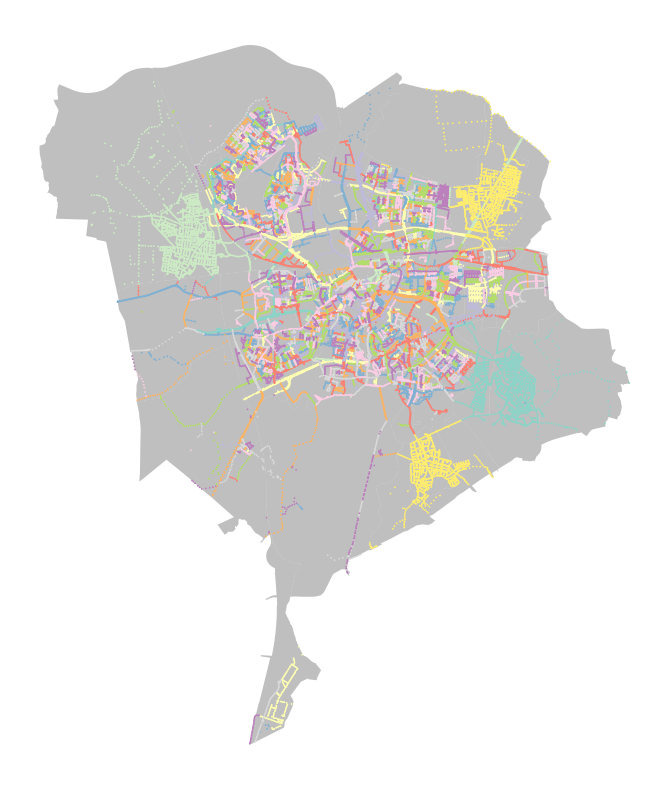

In [332]:
fig, ax = plt.subplots (figsize = (10,10))
map.plot(ax = ax, alpha = 0.5, color = "grey")
lights.plot(ax = ax, marker='^', markersize=.1, cmap='Set3')
ax.set_axis_off()

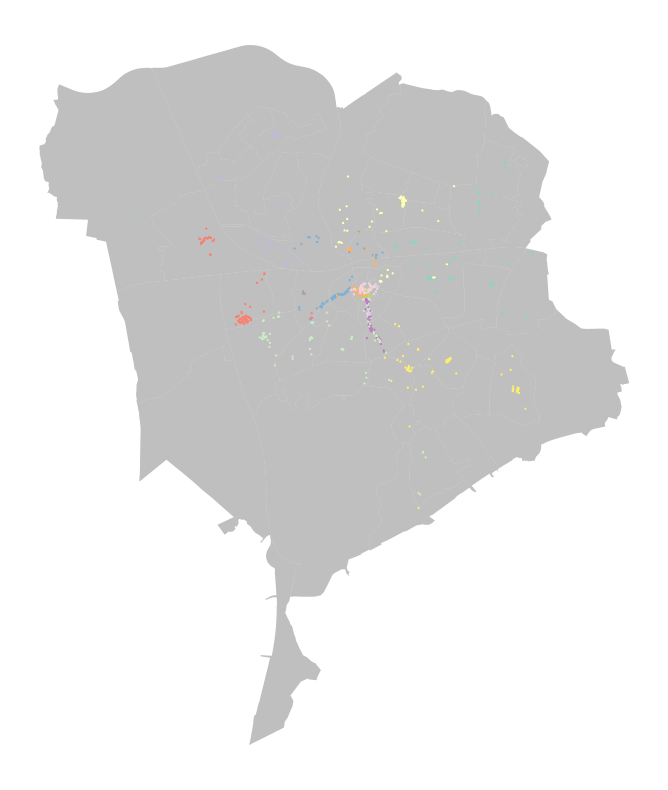

In [333]:
fig, ax = plt.subplots (figsize = (10,10))
map.plot(ax = ax, alpha = 0.5, color = "grey")
poi_area.plot(ax= ax, marker= '^', markersize=.5, cmap='Set3')
ax.set_axis_off()

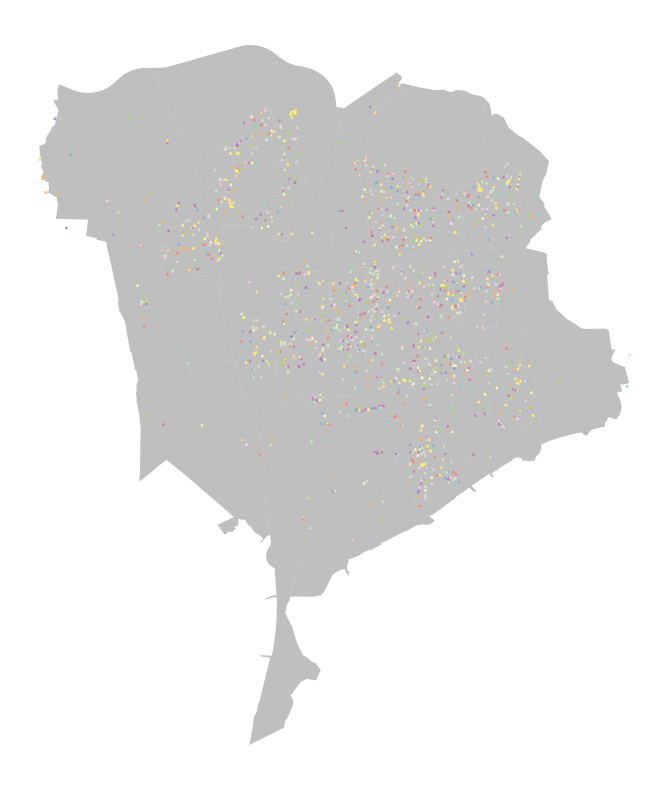

In [334]:
fig, ax = plt.subplots (figsize = (10,10))
map.plot(ax = ax, alpha = 0.5, color = "grey")
benches.plot(ax= ax, marker= '^', markersize=1, cmap='Set3')
ax.set_axis_off()